# Roger Federer Match Length History Pilot Analysis

Now this is exciting ! We will now go beyond analysing generalized (ie. non player specific) match length data and take a look at a specific player : the GOAT Roger Federer. There are several reasons for this choice (many matches at the top level, long career spanning more than two decades, evolution in terms of playstyle) but mainly Federer is my tennis hero.

The goal here is to obtain a series of weighted variables which would allow us to predict the length of a Roger Federer match against a given opponent, under a given set of match conditions. For this, let's implement a decision tree model.

In [345]:
### IMPORTS ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [346]:
### CLEAN FEDERER MATCHES TABLES ###

atp = pd.read_csv("atp_cat.csv")

fed_won = atp[atp["winner_name"] == "Roger Federer"]    # 1163 wins
fed_lost = atp[atp["loser_name"] == "Roger Federer"]    # 261 loses (82% winrate) (1424 matches total)

# We'll drop all of Federer's information except his age
fed_won = fed_won.drop(labels=["winner_name", "winner_hand", "winner_ht", "winner_ioc"], axis=1)
fed_won = fed_won.rename(columns={"winner_age": "fed_age", "winner_rank": "fed_rank", "winner_rank_points": "fed_rank_points",
                                  "loser_name":"opp_name", "loser_hand":"opp_hand", "loser_ht":"opp_ht", "loser_ioc":"opp_ioc", "loser_age":"opp_age",
                                  "loser_rank": "opp_rank", "loser_rank_points": "opp_rank_points"})
fed_won["fed_won"] = "1"

fed_lost = fed_lost.drop(labels=["loser_name", "loser_hand", "loser_ht", "loser_ioc"], axis=1)
fed_lost = fed_lost.rename(columns={"loser_age": "fed_age", "loser_rank": "fed_rank", "loser_rank_points": "fed_rank_points",
                                    "winner_name":"opp_name", "winner_hand":"opp_hand", "winner_ht":"opp_ht", "winner_ioc":"opp_ioc", "winner_age":"opp_age",
                                    "winner_rank": "opp_rank", "winner_rank_points": "opp_rank_points"})
fed_lost["fed_won"] = "0"

fed = pd.concat([fed_won, fed_lost])
fed = fed.drop("Unnamed: 0", axis=1)
fed = fed.reset_index()

fed.head(5)    # Clean Table of all Roger Federer ATP matches

,index,tourney_name,surface,tourney_level,tourney_date,fed_age,opp_name,opp_hand,opp_ht,opp_ioc,opp_age,score,best_of,round,minutes,fed_rank,fed_rank_points,opp_rank,opp_rank_points,fed_won
0,24932,Toulouse,Hard,A,19980928,17.138946,Guillaume Raoux,R,180.0,FRA,28.618754,6-2 6-2,3,R32,60.0,878.0,9.0,45.0,859.0,1
1,24941,Toulouse,Hard,A,19980928,17.138946,Richard Fromberg,R,196.0,AUS,28.418891,6-1 7-6(5),3,R16,85.0,878.0,9.0,43.0,927.0,1
2,25666,Marseille,Hard,A,19990201,17.483915,Carlos Moya,R,190.0,ESP,22.431211,7-6(1) 3-6 6-3,3,R32,113.0,243.0,173.0,5.0,3178.0,1
3,25682,Marseille,Hard,A,19990201,17.483915,Jerome Golmard,L,188.0,FRA,25.396304,6-7(6) 7-6(5) 7-6(5),3,R16,140.0,243.0,173.0,63.0,743.0,1
4,25849,Rotterdam,Carpet,A,19990215,17.522245,Guillaume Raoux,R,180.0,FRA,29.002053,6-7(4) 7-5 7-6(3),3,R32,149.0,178.0,262.0,71.0,691.0,1


## Simple Regression Decision Tree

We will create a simple decision tree using five features :
- Surface  
- Best of  
- Opponent hand  
- Opponent height  
- Ranking difference  

### Exploration & Visualization

In [347]:
# ATP Colors
# Dark blue : #002865
# Light blue : #00AFF0

In [348]:
# Exemple

fed_surface = pd.pivot_table(fed, values="minutes", index = ["best_of", "opp_hand"], columns=["surface"]) # average duration per surface
fed_surface

surface             Carpet        Clay       Grass        Hard
best_of opp_hand                                              
3       L          61.4000   95.363636   72.900000   82.361111
        R          93.1875   88.393750   89.388235   89.526678
5       L              NaN  161.625000  131.315789  131.050000
        R         170.7500  134.097561  124.031579  130.214634

C:\Users\uporito\Anaconda3\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\uporito\Anaconda3\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


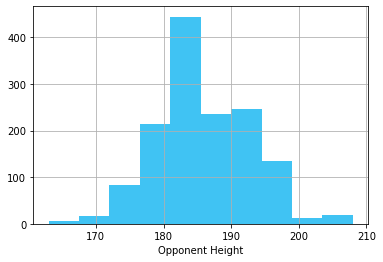

In [349]:
n, bins, patches = plt.hist(fed["opp_ht"], 10, density=False, facecolor='#00AFF0', alpha=0.75)
plt.xlabel('Opponent Height')
plt.ylabel('')
plt.grid(True)
plt.show()

### Formatting

In [350]:
fed1 = fed[["minutes", "surface", "best_of", "opp_hand", "opp_ht"]]
fed1["rank_diff"] = fed["fed_rank"] - fed["opp_rank"]

# One-Hot Encoding
fed1 = pd.get_dummies(data=fed1, columns=["surface", "best_of", "opp_hand"])

fed1 = fed1.dropna(axis=0, how='any')

fed1.head(5)

C:\Users\uporito\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,minutes,opp_ht,rank_diff,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,opp_hand_R
0,60.0,180.0,833.0,0,0,0,1,1,0,0,1
1,85.0,196.0,835.0,0,0,0,1,1,0,0,1
2,113.0,190.0,238.0,0,0,0,1,1,0,0,1
3,140.0,188.0,180.0,0,0,0,1,1,0,1,0
4,149.0,180.0,107.0,1,0,0,0,1,0,0,1


### Regression Decision Tree



#### Pre-processing

For pre-processing we have three options :
- not scaling x or y
- scaling both x and y
- scaling x but not y   
  
I feel like scaling gives us better results but adds a hurdle in interpreting the tree's visualization since it displays scaled values. We can scale both input and output values back, just not display them with sklearns's plot_tree (or any tree visualization that I've found so far). For now, the roundabout solution is just to print out the scaled input and output.

In [351]:
### PRE-PROCESSING ###

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target='minutes'

scale_x = True
scale_y = False

def preprocessing(scale_x=False, scale_y=False) :

    # 1. X, y unscaled
    X = fed1.drop([target], axis=1)
    y = np.asarray(fed1[target])
    y = y.reshape(-1,1)

    xscaler = StandardScaler()
    yscaler = StandardScaler()

    if (scale_x) :
        print("Scaling X...")
        xscaler.fit(X[['opp_ht','rank_diff']])
        X[['opp_ht','rank_diff']] = xscaler.transform(X[['opp_ht','rank_diff']])

    if (scale_y) :
        print("Scaling y...")
        yscaler.fit(y)
        y = yscaler.transform(y)

    display(pd.DataFrame(X).head())
    display(pd.DataFrame(y).head())

    return X, y, xscaler, yscaler

X, y, xscaler, yscaler = preprocessing(scale_x, scale_y)

Scaling X...


,opp_ht,rank_diff,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,opp_hand_R
0,-0.893796,10.281855,0,0,0,1,1,0,0,1
1,1.433962,10.305471,0,0,0,1,1,0,0,1
2,0.561053,3.256308,0,0,0,1,1,0,0,1
3,0.270083,2.571465,0,0,0,1,1,0,1,0
4,-0.893796,1.709507,1,0,0,0,1,0,0,1


,0
0,60.0
1,85.0
2,113.0
3,140.0
4,149.0


#### Exemple of Regression Tree

Taking the "optimal" parameters from our Cross Validation tests, let's build a decision tree and test it out. We then plot out its predictions against the test values, as well as the tree itself. I have a problem with the tree_plot as it shows the scaled input and output values, making its interpretation less intuitive.

Testing score :  0.27282040140374986


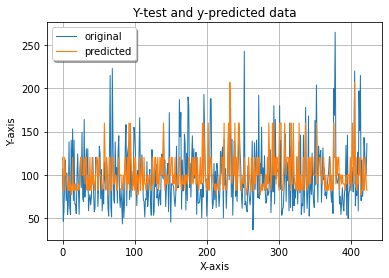

[Text(837.0, 713.475, 'best_of_5 <= 0.5\nmse = 1735.444\nsamples = 984\nvalue = 103.329'),
 Text(418.5, 509.625, 'rank_diff <= 0.287\nmse = 897.23\nsamples = 681\nvalue = 89.84'),
 Text(209.25, 305.775, 'rank_diff <= -0.068\nmse = 763.697\nsamples = 454\nvalue = 85.762'),
 Text(104.625, 101.92499999999995, 'mse = 636.653\nsamples = 214\nvalue = 81.897'),
 Text(313.875, 101.92499999999995, 'mse = 851.782\nsamples = 240\nvalue = 89.208'),
 Text(627.75, 305.775, 'rank_diff <= 0.977\nmse = 1064.524\nsamples = 227\nvalue = 97.996'),
 Text(523.125, 101.92499999999995, 'mse = 1065.677\nsamples = 211\nvalue = 99.616'),
 Text(732.375, 101.92499999999995, 'mse = 557.984\nsamples = 16\nvalue = 76.625'),
 Text(1255.5, 509.625, 'rank_diff <= 0.369\nmse = 2291.232\nsamples = 303\nvalue = 133.647'),
 Text(1046.25, 305.775, 'surface_Carpet <= 0.5\nmse = 1467.777\nsamples = 220\nvalue = 120.786'),
 Text(941.625, 101.92499999999995, 'mse = 1368.202\nsamples = 219\nvalue = 120.091'),
 Text(1150.875, 101.

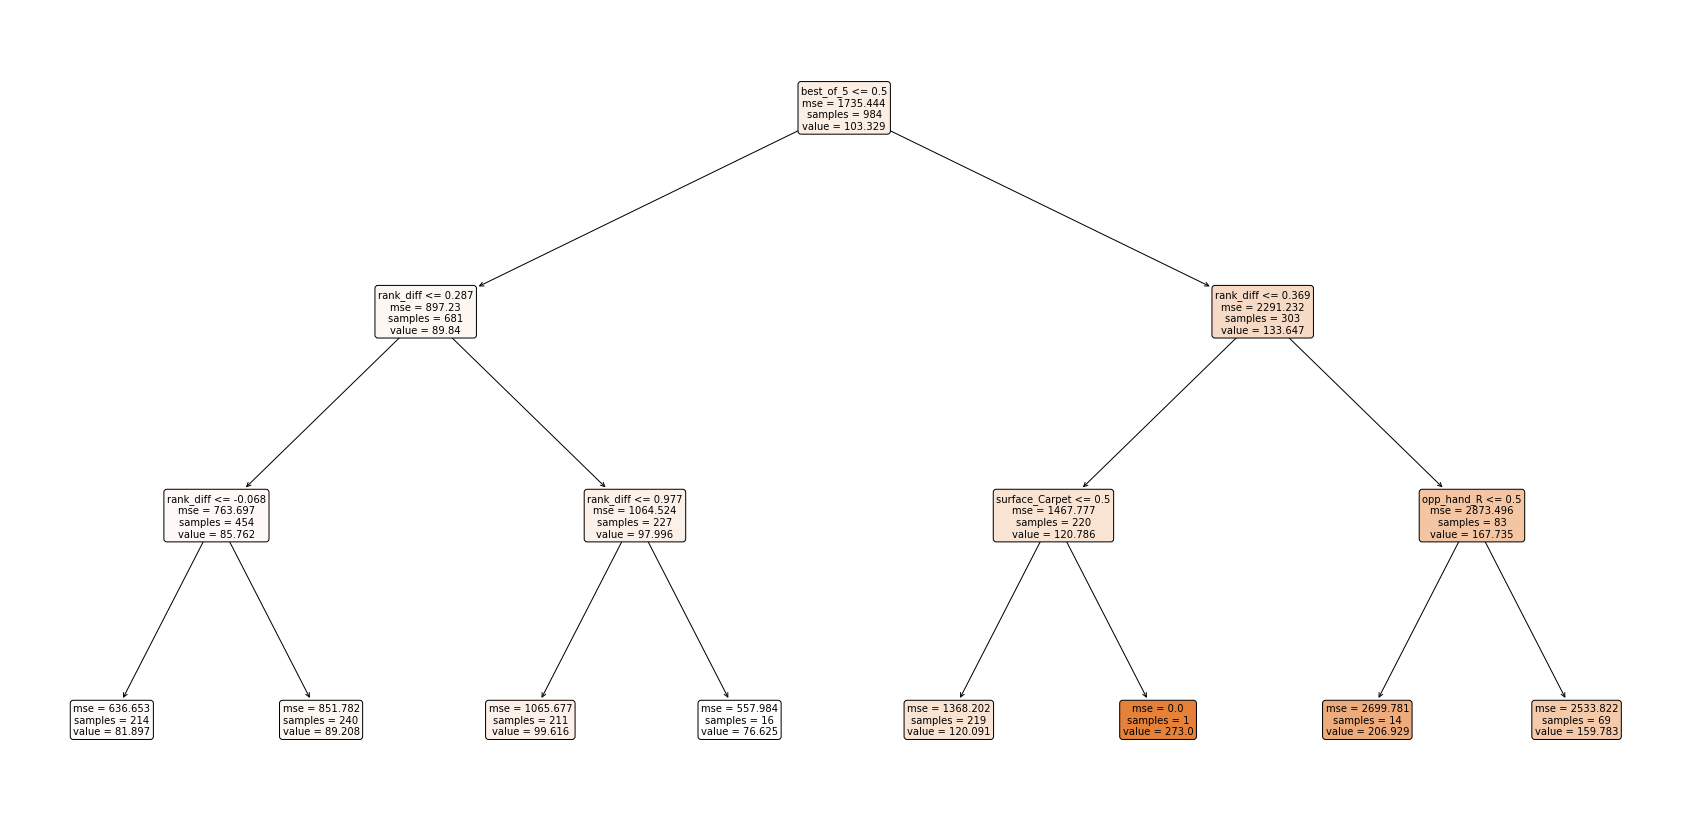

In [352]:
### BUILDING THE TREE ###

dtr = DecisionTreeRegressor(max_depth=3, min_samples_split=.05)

# Training :

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.3)
dtr.fit(Xtrain, ytrain)

# Testing :

ypred = dtr.predict(Xtest)

print("Testing score : ", dtr.score(Xtest, ytest))

x_ax = range(len(ytest))
plt.plot(x_ax, ytest, linewidth=1, label="original")
plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
plt.title("Y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

plt.figure(figsize=(30,15))
tree.plot_tree(dtr,
          filled=True,
          rounded=True,
          fontsize=10,
          feature_names=["opp_ht", "rank_diff", "surface_Carpet", "surface_Clay", "surface_Grass", "surface_Hard", "best_of_3", "best_of_5", "opp_hand_L", "opp_hand_R"])

# plt.savefig('tree_high_dpi', dpi=600)

Now let's try to predict the length of a match with custom input :  
To make interpreting the tree above possible, in case of scaling, we will print out the input and/or output after scaling.

In [353]:
### CUSTOM PREDICTION ###

def predict(scale_x, scale_y, height, rank_diff, surface, best_of, hand) :
    # surface : carpet(1), clay(2), grass(3), clay(4)
    # best of : 3(1), 5(2)
    # hand : left(1), right(2)

    surface_input = [0, 0, 0, 0]
    surface_input[surface - 1] = 1

    bo_input = [0, 0]
    bo_input[best_of - 1] = 1

    hand_input = [0, 0]
    hand_input[hand - 1] = 1

    if (not scale_x and not scale_y) :  # 1. X, y unscaled
        input = [height, rank_diff] + surface_input + bo_input + hand_input
        print("Input : ", input)
        input = [input]

        print("Prediction : ", dtr.predict(input), " minutes")

    # input = [180, 0, 0, 1, 0, 0, 0, 1]

    elif (scale_x and scale_y) :    # 2. X, y scaled
        input = xscaler.transform([[height, rank_diff]])
        input = np.append(input[0], surface_input + bo_input + hand_input)
        print("Scaled input : ", input)

        input = [input]

        print("Scaled Prediction : ", dtr.predict(input), " minutes")
        print("Prediction : ", yscaler.inverse_transform(dtr.predict(input)), " minutes")

    elif (scale_x and not scale_y) :    # 3. X scaled, y unscaled
        input = xscaler.transform([[180, 0]])
        input = np.append(input[0], surface_input + bo_input + hand_input)
        print("Scaled input : ", input)
        input = [input]

        print("Prediction : ", dtr.predict(input), " minutes")

    return(dtr.predict(input))

prediction = predict(scale_x, scale_y, 180, 0, 2, 1, 1)

Scaled input :  [-0.89379627  0.44608889  0.          1.          0.          0.
  1.          0.          1.          0.        ]
Prediction :  [99.61611374]  minutes


#### Interpretation

There are a few observations to be made.  
On the subject of the tree's structure, the best trees are quite shallow (3 levels). This avoids overfitting.  
Next, the best-of 3 or 5 distinction is the most important feature, by far. The split along this feature is always the root split, and this should come at no surprise.
However, the surface distinction, surprisingly, doesn't seem that important. The level 2 splits almost always relate to the rank_diff feature, as do most of the subsequent splits. Usually a few random splits on surface, hand or height will show up in the last level.

### Cross Validation

We want to find good values for our parameters and to get an an idea of how our regression trees compare to each other. In order to do that, we will do a K-fold validation, with K = 10.

In [354]:
# Parameters

K = 10

MAX_DEPTH=np.arange(3, 15)
MIN_SAMPLE=[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.075, 0.001]
# MAX_DEPTH=np.arange(3, 5)   # d depths
# MIN_SAMPLE=[0.1]            # s sample ratios

# We will define d x s Regression Trees RT(d,s)

![score formula](res/score.png "sklearn score")

In [355]:
# Basic Error Loop

scores = [[] for n in range(len(MAX_DEPTH))]   # sklearn Decision Tree score (max = 1)
MSE = [[] for n in range(len(MAX_DEPTH))]      # Mean Squared Error
RMSE = [[] for n in range(len(MAX_DEPTH))]     # Root Mean Squared Error

for i in range(len(MAX_DEPTH)) :

    for j in range(len(MIN_SAMPLE)) :

        d = MAX_DEPTH[i]
        s = MIN_SAMPLE[j]

        # print(f"Max depth : {d} , Min sample : {s}")

        dtr = DecisionTreeRegressor(max_depth=d, min_samples_split=s)

        dtr.fit(Xtrain, ytrain)

        score = dtr.score(Xtest, ytest)   
        scores[i].append(score)
        # print(f"score : {score}.")

        Ypred = dtr.predict(Xtest)

        mse = mean_squared_error(ytest, Ypred)  # mean of (y_true - y_pred)**2

        MSE[i].append(mse)
        # print(f"MSE : {mse}.")

scores_df = pd.DataFrame(data=scores, index=MAX_DEPTH, columns=MIN_SAMPLE)
index = scores_df.index
index.name = "scores"
display(scores_df)
MSE_df = pd.DataFrame(data=MSE, index=MAX_DEPTH, columns=MIN_SAMPLE)
index = MSE_df.index
index.name = "MSE"
display(MSE_df)

# Display scores

print("Mean score : ", np.mean(scores))

N = np.argmax(scores)
print(f"Optimal Regressor Tree parameters : d = {MAX_DEPTH[N // len(MIN_SAMPLE)]}, s = {MIN_SAMPLE[N % len(MIN_SAMPLE)]}")
print("Best score : ", scores[N // len(MIN_SAMPLE)][N % len(MIN_SAMPLE)])

,0.500,0.400,0.300,0.200,0.100,0.050,0.075,0.001
scores,,,,,,,,
3,0.258509,0.265308,0.257685,0.256515,0.256515,0.272820,0.272820,0.272820
4,0.258509,0.265308,0.257685,0.268782,0.268782,0.251708,0.285087,0.248384
5,0.258509,0.265308,0.257685,0.268782,0.249418,0.203103,0.261018,0.199544
6,0.258509,0.265308,0.257685,0.268782,0.219475,0.133204,0.191172,0.062771
7,0.258509,0.265308,0.257685,0.268782,0.218659,0.139765,0.197019,0.111700
8,0.258509,0.265308,0.257685,0.268782,0.218659,0.137378,0.196432,0.079007
9,0.258509,0.265308,0.257685,0.268782,0.218659,0.132760,0.196686,0.002877
10,0.258509,0.265308,0.257685,0.268782,0.218659,0.119647,0.196686,-0.161745
11,0.258509,0.265308,0.257685,0.268782,0.218659,0.108437,0.196686,-0.176488


,0.500,0.400,0.300,0.200,0.100,0.050,0.075,0.001
MSE,,,,,,,,
3,1020.565437,1011.207959,1021.700375,1023.310042,1023.310042,1000.868315,1000.868315,1000.868315
4,1020.565437,1011.207959,1021.700375,1006.427072,1006.427072,1029.926127,983.985346,1034.501458
5,1020.565437,1011.207959,1021.700375,1006.427072,1033.078915,1096.825523,1017.112111,1101.723585
6,1020.565437,1011.207959,1021.700375,1006.427072,1074.291571,1193.032840,1113.247210,1289.973851
7,1020.565437,1011.207959,1021.700375,1006.427072,1075.414390,1184.001777,1105.199092,1222.630009
8,1020.565437,1011.207959,1021.700375,1006.427072,1075.414390,1187.286692,1106.006975,1267.627623
9,1020.565437,1011.207959,1021.700375,1006.427072,1075.414390,1193.643674,1105.658066,1372.409680
10,1020.565437,1011.207959,1021.700375,1006.427072,1075.414390,1211.691748,1105.658066,1598.990764
11,1020.565437,1011.207959,1021.700375,1006.427072,1075.414390,1227.121036,1105.658066,1619.282506


Mean score :  0.20214642854559836
Optimal Regressor Tree parameters : d = 4, s = 0.075
Best score :  0.2850867013263392


In [356]:
CV = model_selection.KFold(n_splits=K,shuffle=True)

test_errors = [[[]for n in range(len(MIN_SAMPLE))] for n in range(len(MAX_DEPTH))]  # list of K test errors for every RT(d,s) Regression Tree

k=0

for train_index, test_index in CV.split(X, y):
    # Cross-validation loop

    print(f'   K-validation fold: {k+1}/{K}')  
    
    # extract training and test set for current CV fold
    # X_Kj_train = X[train_index,:]
    X_Kj_train = pd.DataFrame(X).iloc[train_index]
    y_Kj_train = pd.Series(y.reshape(1,-1)[0]).iloc[train_index]
    # X_Kj_test = X[test_index,:]
    X_Kj_test = pd.DataFrame(X).iloc[test_index]
    y_Kj_test = pd.Series(y.reshape(1,-1)[0]).iloc[test_index]

	# Fit and evaluate models
    for i in range(len(MAX_DEPTH)) :

        for j in range(len(MIN_SAMPLE)) :

            d = MAX_DEPTH[i]
            s = MIN_SAMPLE[j]

            # print(f"Max depth : {d} , Min sample : {s}")

            dtr = DecisionTreeRegressor(max_depth=d, min_samples_split=s)

            dtr.fit(X_Kj_train, y_Kj_train)

            score = dtr.score(X_Kj_train, y_Kj_train)   

            Ypred_Kj = dtr.predict(X_Kj_test)

            mse = mean_squared_error(y_Kj_test, Ypred_Kj)
            test_errors[i][j].append(mse)

    k+=1

# print("[Test errors] :")
# print(test_errors)
gen_error = np.sum(test_errors, axis=2)
print("[Generalized errors] :")
display(pd.DataFrame(gen_error))
N = np.argmin(gen_error)
print(f"Optimal Regressor Tree parameters : d = {MAX_DEPTH[N // len(MIN_SAMPLE)]}, s = {MIN_SAMPLE[N % len(MIN_SAMPLE)]}")

   K-validation fold: 1/10
   K-validation fold: 2/10
   K-validation fold: 3/10
   K-validation fold: 4/10
   K-validation fold: 5/10
   K-validation fold: 6/10
   K-validation fold: 7/10
   K-validation fold: 8/10
   K-validation fold: 9/10
   K-validation fold: 10/10
[Generalized errors] :


,0,1,2,3,4,5,6,7
0,12355.072546,12262.787603,11568.484152,11404.894031,11404.894031,11151.344111,11175.599374,11151.344111
1,12355.072546,12262.787603,11568.484152,11421.791249,11561.553262,11524.976207,11348.923281,11707.157667
2,12355.072546,12262.787603,11568.484152,11410.416382,11624.771764,11613.531896,11457.286259,11836.064625
3,12355.072546,12262.787603,11568.484152,11399.449623,11612.217923,11698.600858,11476.040771,12118.262961
4,12355.072546,12262.787603,11568.484152,11399.449623,11572.547915,11771.815793,11532.203328,12903.857683
5,12355.072546,12262.787603,11568.484152,11399.449623,11581.362926,11929.039451,11614.086346,14534.210012
6,12355.072546,12262.787603,11568.484152,11399.449623,11563.021004,11967.291173,11604.616240,15603.859614
7,12355.072546,12262.787603,11568.484152,11399.449623,11559.650762,12025.046248,11642.841196,17239.724406
8,12355.072546,12262.787603,11568.484152,11399.449623,11566.779040,12028.550579,11647.335777,18164.981710
9,12355.072546,12262.787603,11568.484152,11399.449623,11566.779040,12048.960121,11656.188268,19134.088393


Optimal Regressor Tree parameters : d = 3, s = 0.05


### Conclusion

Here are the best scores for the 3 different pre-processing options :

x,y scaled : 0.303812186321178  
x,y unscaled : 0.2507916729068349  
x scaled, y unscaled : 0.2850867013263392  

These scores aren't terrible, but they do present a lot of variance. I think there is some merit to decision trees, but they are quite inconsistent. Now whether that is because decision trees aren't optimal for our application, because we haven't pushed the model far enough or because the dataset is inherently susceptible to inconsistent predictions remains to be seen.